# Workspace preparation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing


# Data loading & preparing

In [0]:
df_labels_1 = pd.read_csv("/content/gdrive/My Drive/CourseWork/labels_1.csv")
df_labels_2 = pd.read_csv("/content/gdrive/My Drive/CourseWork/labels_2.csv")
df_data_1 = pd.read_csv("/content/gdrive/My Drive/CourseWork/df_1.csv")
df_data_2 = pd.read_csv("/content/gdrive/My Drive/CourseWork/df_2.csv")

df_labels = [df_labels_1, df_labels_2]
df_data = [df_data_1, df_data_2]

In [133]:
df_labels_1.head()

,Unnamed: 0,start,end,move
0,0,188973,190533,lunge
1,1,196611,198171,lunge
2,2,203674,205234,lunge
3,3,210737,212296,lunge
4,4,218045,219606,lunge


In [269]:
df_data_1.head()

,Unnamed: 0,tm,ax,ay,az,gx,gy,gz
0,0,9245,9.409692,-2.399112,0.445344,0.029209,0.029209,0.029209
1,1,9327,9.601238,-2.408690,0.627313,-0.391843,-0.391843,-0.391843
2,2,9409,9.275610,-2.140525,1.034348,-0.360551,-0.360551,-0.360551
3,3,9491,9.711377,-1.379130,1.599408,-0.317407,-0.317407,-0.317407
4,4,9574,9.342651,-1.350399,2.169257,-0.435786,-0.435786,-0.435786


In [0]:
def pad_data(lst, desired_length):
    additional_length = desired_length - len(lst)
    left_part = (additional_length)//2
    right_part = additional_length - left_part
    data_to_fill = np.mean(lst)
    return np.concatenate(
        (
            np.ones(left_part) * data_to_fill,
            lst,
            np.ones(right_part) * data_to_fill,
        )
    )

In [0]:
def element_to_input(id, data_df, label_df, le, norm_length,x, y):
    index = label_df.iloc[id,:]
    elem = data_df[data_df["tm"].between(index["start"], index["end"], inclusive=True)]
    if len(elem) == 0:
        return
    np_elem = np.stack(
        (
            pad_data(elem["ax"].values, norm_length),
            pad_data(elem["ay"].values, norm_length),
            pad_data(elem["az"].values, norm_length),
            pad_data(elem["gx"].values, norm_length),
            pad_data(elem["gy"].values, norm_length),
            pad_data(elem["gz"].values, norm_length),
        )
    )
    x.append(np_elem)
    y.append(le.transform([index["move"]])[0])

# Data investigation

In [0]:
def draw(id, data, labels):
    elem = labels.iloc[id,:]
    print(elem["move"])
    plt.figure(0)
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["ax"])
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["ay"])
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["az"])
    plt.figure(1)
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["gx"])
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["gy"])
    plt.plot((data[data["tm"].between(elem["start"], elem["end"], inclusive=True)])["gz"])
    plt.show()

lunge


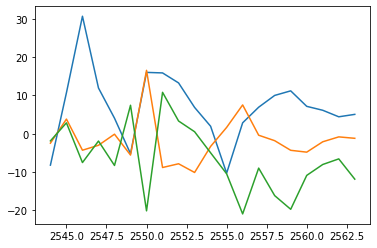

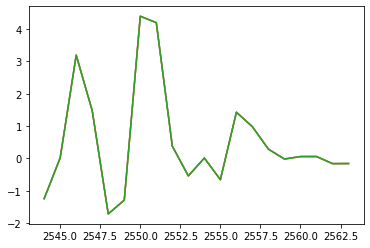

In [138]:
draw(4, df_data_1, df_labels_1)

In [0]:
import scipy.signal as signal

In [315]:
from pylab import rcParams
rcParams['figure.figsize'] = 200, 5

plt.figure(0)
plt.title("Original data")
for i in range(len(df_labels_1)):
    elem = df_labels_1.iloc[i, :]
    plt.axvspan(elem["start"], elem["end"], alpha=0.1, color='green' if elem["move"] == "lunge" else 'red')

plt.plot(df_data_1["tm"], df_data_1["ax"]+50)
plt.plot(df_data_1["tm"], df_data_1["ay"])
plt.plot(df_data_1["tm"], df_data_1["az"]-50)

plt.figure(1)
plt.title("FFT")
plt.ylim(top=4000)
plt.ylim(bottom=-4000)

for i in range(len(df_labels_1)):
    elem = df_labels_1.iloc[i, :]
    plt.axvspan(elem["start"], elem["end"], alpha=0.1, color='green' if elem["move"] == "lunge" else 'red')

plt.plot(df_data_1["tm"], np.fft.fft(df_data_1["ax"]) + 1000)
plt.plot(df_data_1["tm"], np.fft.fft(df_data_1["ay"]))
plt.plot(df_data_1["tm"], np.fft.fft(df_data_1["az"]) - 1000)

Output hidden; open in https://colab.research.google.com to view.

In [313]:
b1 = signal.firwin(40, 0.5)
plt.plot(df_data_1["tm"], np.fft.fft(df_data_1["ax"]))

ValueError: ignored

# Model fitting

## Prepare data for training

In [0]:
X=[]
y=[]
le = preprocessing.LabelEncoder()
le.fit(df_labels_1["move"])

for df_index in range(len(df_labels)):
    for i in range(len(df_labels[df_index])):
        element_to_input(i, df_data[df_index], df_labels[df_index], le, 20, X, y)

In [0]:
Y = to_categorical(y)

## Convolution model

In [0]:
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical

In [0]:
n_features = 6
n_timesteps = 20
n_outputs = 2

In [0]:
model_conv = Sequential()
model_conv.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features, n_timesteps)))
model_conv.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(n_outputs, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [244]:
model_conv.fit(np.array(X).reshape((-1, 6, 20)), Y, batch_size=1, validation_split=0.3, epochs=47)

Train on 48 samples, validate on 21 samples
Epoch 1/47
48/48 [==============================] - 1s 17ms/step - loss: 1.1447 - acc: 0.6458 - val_loss: 1.6858 - val_acc: 0.5238
Epoch 2/47
48/48 [==============================] - 0s 2ms/step - loss: 0.6578 - acc: 0.7917 - val_loss: 0.3510 - val_acc: 0.9048
Epoch 3/47
48/48 [==============================] - 0s 2ms/step - loss: 0.3885 - acc: 0.8958 - val_loss: 0.3683 - val_acc: 0.9048
Epoch 4/47
48/48 [==============================] - 0s 2ms/step - loss: 0.2557 - acc: 0.8750 - val_loss: 0.3752 - val_acc: 0.8095
Epoch 5/47
48/48 [==============================] - 0s 2ms/step - loss: 0.2396 - acc: 0.9167 - val_loss: 0.8250 - val_acc: 0.7619
Epoch 6/47
48/48 [==============================] - 0s 2ms/step - loss: 0.0691 - acc: 0.9792 - val_loss: 0.4493 - val_acc: 0.8571
Epoch 7/47
48/48 [==============================] - 0s 2ms/step - loss: 0.3875 - acc: 0.9792 - val_loss: 0.3931 - val_acc: 0.9524
Epoch 8/47
48/48 [===========================

## Dense model